# Práctica 2 - Image stitching

## Introducción 

En esta segunda práctica se pretende realizar una panorámica entre dos imágenes empleando homografías. La selección de puntos en ambas imágenes se realizará de forma automática mediante los métodos SIFT, SURF, ORB y FAST + BRIEF. Todos estos métodos ya se incluyen en la librería OpenCV, por lo que se hará uso de las funciones ya integradas. 

Link al github: https://github.com/MarcBalle/Visio_per_computador/tree/main/Práctica2_Image_stitching

### Inclusión de las librerías necesarias

In [40]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

Primero de todo se definen una serie de funciones comunes a los cuatro métodos implementados. 

### get_kp_desc ( )

Esta función se encarga de instanciar los objetos de las clases pertinentes a cada método y calcular la lista de _keypoints_ y descriptores de la imagen pasada como parámetro.

In [41]:
def get_kp_desc(method: str, img: np.ndarray, **kwargs):
    
    method_call = None

    if method == "O":
        orb = cv2.ORB_create(**kwargs)
        method_call = orb.detectAndCompute
    elif method == "sift":
        sift = cv2.xfeatures2d.SIFT_create(**kwargs)
        method_call = sift.detectAndCompute
    elif method == "fast_brief":
        fast = cv2.FastFeatureDetector_create() # Create FAST object with default values
        brief = cv2.xfeatures2d.BriefDescriptorExtractor_create() #Creating BRIEF object with default values
        kp = fast.detect(img, None)
        kp, descs = brief.compute(img, kp)
        return kp, descs
    elif method == "surf":
        surf = cv2.xfeatures2d.SURF_create(400) #threshold of the Hessian determinant. Value found in web
        method_call = surf.detectAndCompute


    kp, descs = method_call(img, mask=None, **kwargs) #SIFT, ORB y SURF

    return kp, descs

### match_descriptors ( )

Esta función se encarga de realizar los _matches_ entre descriptores de las dos imágenes. El método fundamental en este paso el la fuerza bruta. Esta consiste en evaluar cada descriptor de la primera imagen con todos los de la segunda imagen. En cada una de estas evaluaciones se calcula la distancia entre los descriptores (similaritud). Para ello se ofrecen dos posibilidades: 
    
   1. Fuerza bruta con la distancia de Hamming. Esta opción será requerida cuando los descriptores sean binarios (ORB y BRIEF). Esta opción devolverá el _match_ con el descriptor más cercano o similar.
   2. Fuerza bruta con la distancia Euclidea ( _default_ ). Esta opción será requerida cuando los descriptores sean de coma flotante (SIFT y SURF). Esta opción devolverá los _matches_ con los dos descriptores más cercanos o similares.

Para ello únciamente instancia el objeto de la clase de _matcher_ pertinente y calcula los _matches_ , devolviendo una lista de clases _DMatch_ . Esta clase contendrá tres parámetros básicos: 
    
   1. queryIdx. Índice del descriptor en la primera imagen. 
   2. trainIdx. Índice del descriptor en la segunda imagen.
   3. distance. Distancia entre los descriptores enlazados. 

In [42]:
def match_descriptors(method: str, desc1, desc2, **kwargs):
    
    matches = None
    if method == "D":
        matcher = cv2.DescriptorMatcher_create(
            cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
        matches = matcher.match(desc1, desc2) #, **kwargs)
    elif method == "F":
        matcher = cv2.BFMatcher()
        matches = matcher.knnMatch(desc1, desc2, **kwargs)

    return matches

### filter_matches ( )

Finalmente esta función filtrará los _matches_ con tal de obtener únicamente aquellos más relevantes o fiables. Para ello, y en función del método empleado, se definen dos formas de realizar el cribado: 

   1. Cribado basado en umbral. Si la distancia entre descriptores es menor a un cierto umbral, se acepta el enlace. Este método se aplica para los descriptores hallados con ORB y BRIEF, ya que, como se ha comentado, únicamente dispondremos de un _match_ por descriptor, a diferencia de con SIFT y SURF, que nos quedaremos en un principio con los dos más cercanos. 
   
   2. NNDR ( _Nearest Neighbor Distance Ratio_ ). En este caso se realiza el cociente entre la distancia al primer descriptor más cercano y el segundo. Si dicho cociente es menor a un umbral, se acepta el _match_ . Este método tiene como objetivo aceptar un enlace entre descriptores siempre y cuando el segundo descriptor más cercano este lo suficientemente lejos del primero, asegurando una cierta fiabilidad en el enlace. 

In [43]:
def filter_matches(method: str, matches, min_distance: int = None,
                   proportion: float = None): 
    if method == "DIST":
        matches = list(filter(lambda m: m.distance < min_distance, matches))
    elif method == "KNN":
        matches = list(
            filter(lambda m: m[0].distance < m[1].distance * proportion,
                   matches))

    return matches

## Image stitching

En esta sección se mostrará cómo se ha realizado el _image stitching_ empleando los distintos métodos. 

### Se cargan las imágenes

In [44]:
right_house = cv2.imread("./in/casa1.jpeg",0)
left_house = cv2.imread("./in/casa2.jpeg",0)

### SIFT ( _Scale Invariant Feature Transform_ )

#### Características generales 
   - Detecta _keypoints_ y crea descriptores. 
   - Detección de _keypoints_ en diferentes escalas (octavas) de la imagen haciendo uso de una aproximación al LoG ( _Laplacian of Gaussian_ ) con la resta de imagenes filtradas por un kernel Guassiano, entre otros pasos. 
   - Uso de un vector de dimensión 128 en coma flotante para los descriptores de los _keypoints_ . 
 

Se hallan los _keypoints_ y los descriptores

In [45]:
kp1, desc1 = get_kp_desc(method="sift", img=right_house)
kp2, desc2 = get_kp_desc(method="sift", img=left_house)

Se realiza el _matching_ entre imágenes. En este caso se seleccionan los dos mejores matches por cada descriptor de la primera imagen (right_house), $k = 2$. Como ya se ha comentado, se realiza el enlace evaluando la distancia Euclidea ("F")

In [46]:
matches = match_descriptors(method="F", desc1=desc1, desc2=desc2, k=2) # k = 2 -> Dos mejores matches

Se dibujan los enlaces encontrados. El flag _cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS_ indica que solo se dibujen los _keypoints_ con enlance. 

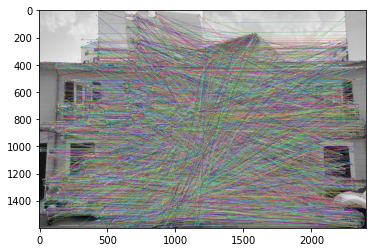

In [47]:
res = cv2.drawMatches(right_house, kp1, left_house, kp2,
                          [m[0] for m in matches], None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(res)
plt.show()

Se filtran los enlaces encontrados con el métodos NNDR con un umbral de 0.7

In [48]:
matches = filter_matches(method="KNN", matches=matches, proportion=0.7)                                         

Se almacenan las coordenadas de los _kepoints_ enlazados en cada imagen.

In [49]:
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp1[match[0].queryIdx].pt
    points2[i, :] = kp2[match[0].trainIdx].pt


Se realiza la homografía con dichos puntos. El parámetro cv2.RANSAC habilita el funcionamiento algoritmo RANSAC ( _Random Sample Consesus_ ), el cual asegura el cálculo robusto de la homografía en presencia de _matches_ incorrectos incluso después del filtrado. 

In [50]:
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

Una vez encontrada la homgrafía, se aplica sobre la imagen. El único detalle a tener en cuenta son los tamaños finales de la imagen resultante con tal de poder realizar posteriormente la panorámica. 

Para esto último declaramos que el ancho de la imagen transformada sea igual a la suma del ancho de las imágenes originales. Finalmente agregamos la imagen original de la parte izquierda ( _left_house_ ) en el correspondiente sitio de la imagen transformada, creando la sensación de una imagen panorámica. 

In [51]:
height, width = right_house.shape

im1Reg = cv2.warpPerspective(right_house, h, (width + left_house.shape[1],height))
im1Reg[0:left_house.shape[0], 0:left_house.shape[1]] = left_house

Finalmente se muestra el resultado

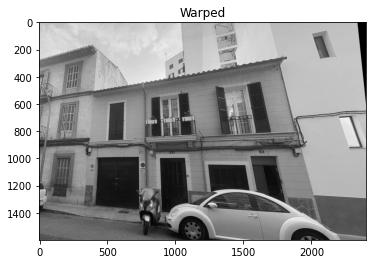

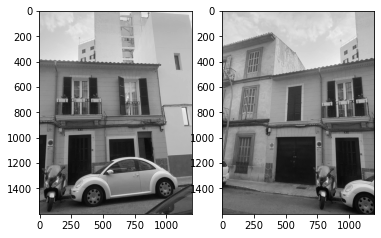

In [52]:
plt.plot()
plt.title("Warped")
plt.imshow(im1Reg, cmap="gray")

plt.show()

plt.subplot(1, 2, 1)
plt.imshow(right_house, cmap="gray")

plt.subplot(1, 2, 2)
plt.imshow(left_house, cmap="gray")

plt.show()

En las siguientes secciones se siguen los mismos pasos, así que solo se limitará a explicar o indicar detalles de las implementaciones o sus resultados. 

### SURF ( _Speed Up Robust Features_ )

#### Características generales

   - Detecta _keypoints_ y crea descriptores. 
   - A diferencia de SIFT, donde el LoG se aproxima mediante la resta de Gaussianas, SURF realiza dicha   aproximación con la aplicación de máscaras mediante la convolución. 
   - Usa un vector de dimensión 64 en coma flotante para los descriptores. 
   - Gracias a las dos últimas características, es más rápido que SIFT. 

In [53]:
kp1, desc1 = get_kp_desc(method="surf", img=right_house)
kp2, desc2 = get_kp_desc(method="surf", img=left_house)

In [54]:
matches = match_descriptors(method="F", desc1=desc1, desc2=desc2, k=2) # k = 2 -> Dos mejores matches

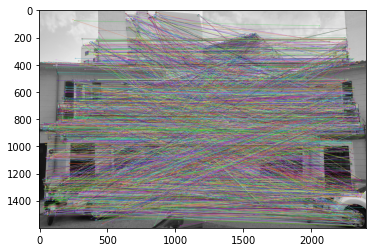

In [55]:
res = cv2.drawMatches(right_house, kp1, left_house, kp2,
                          [m[0] for m in matches], None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(res)
plt.show()

In [56]:
matches = filter_matches(method="KNN", matches=matches, proportion=0.7) 

In [57]:
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp1[match[0].queryIdx].pt
    points2[i, :] = kp2[match[0].trainIdx].pt



In [58]:
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

In [59]:
height, width = right_house.shape

im1Reg = cv2.warpPerspective(right_house, h, (width + left_house.shape[1],height))
im1Reg[0:left_house.shape[0], 0:left_house.shape[1]] = left_house

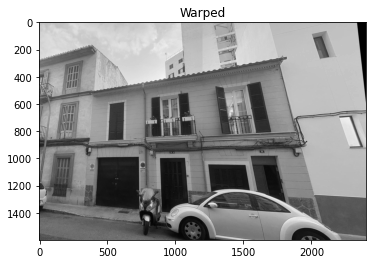

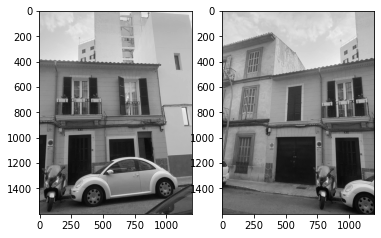

In [60]:
plt.plot()
plt.title("Warped")
plt.imshow(im1Reg, cmap="gray")

plt.show()

plt.subplot(1, 2, 1)
plt.imshow(right_house, cmap="gray")

plt.subplot(1, 2, 2)
plt.imshow(left_house, cmap="gray")

plt.show()

### ORB ( _Oriented FAST and Rotated BRIEF_ )

#### Características generales

   - Detecta _keypoints_ y crea descriptores. 
   - Utiliza el método FAST en primera instancia para detectar puntos clave. 
   - Depura los _keypoints_ encontrados con el métodos de Harris. 
   - Emplea BRIEF para crear los descriptores. Son descriptores biniarios. 
   - Ligero a nivel computacional.
   - Open source, a diferencia de SIFT y SURF

In [61]:
kp1, desc1 = get_kp_desc(method="O", img=right_house)
kp2, desc2 = get_kp_desc(method="O", img=left_house)

En este caso, al tratarse de descriptores binarios, se evalua la distancia de Hamming para el emparejamiento de descriptores. Dicho método se basa en la suma de dígitos diferentes entre dos conjuntos binarios. 

En este caso da igual que le pasemos el argumento de $k = 2$ o no, ya que este no se va a incluir en la llamada al método de emparejamiento. 

In [62]:
matches = match_descriptors(method="D", desc1=desc1, desc2=desc2, k=2)

En este caso, para dibujar los _matches_ no es necesario escoger la primera clase DMatch (correspondiente al enlace con el descriptor más cercano en SIFT y SURF) de la lista de _matches_ para cada _keypoint_ , ya que tanto para ORB como para FAST + BRIEF solo se enlaza cada descriptor con el más cercano (a diferencia de SIFT y SURF donde se elegían los dos más cercanos).

Es notorio observar como este método encuentra muchos menos _matches_ que el resto, tal y como se observa en la figura de abajo. Esto puede ser debido al refinamiento de los puntos clave con Harris, el cual solo detecta esquinas.

Además, si uno se fija, al haber menor cantidad de enlaces dibujados se pueden observar algunos erróneos. Esto lógicamente también pasa en los otros métodos, pero no es tan fácil localizarlos visualmente. 

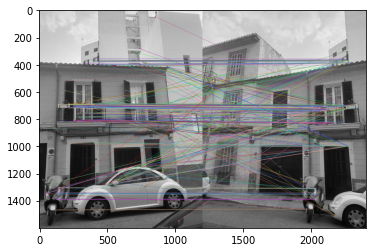

In [63]:
res = cv2.drawMatches(right_house, kp1, left_house, kp2,
                          [m for m in matches], None, #m[0] en SIFT y SURF
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(res)
plt.show()

En este caso se ha escogido como distancia umbral el valor 64 para filtrar los _matches_ ya que fue la que se encontró como recomendada en varios sitios. Sin embargo, se ha comprobado que para las imágenes escogidas es posible seleccionar valores más bajos sin que afecte al resultado, filtrando de esta forma mejores enlaces. 

In [64]:
matches = filter_matches(method="DIST", matches=matches, min_distance=64)

In [65]:
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt

In [66]:
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

In [67]:
height, width = right_house.shape
im1Reg = cv2.warpPerspective(right_house, h, (width + left_house.shape[1],height))
im1Reg[0:left_house.shape[0], 0:left_house.shape[1]] = left_house

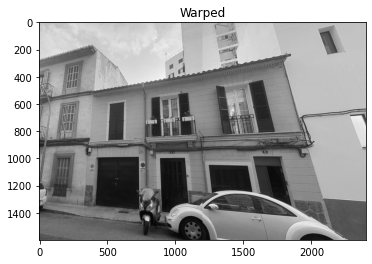

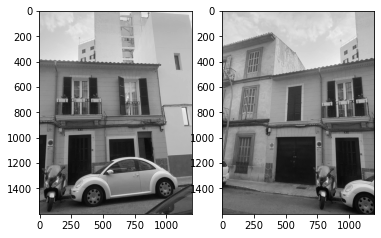

In [68]:
plt.plot()
plt.title("Warped")
plt.imshow(im1Reg, cmap="gray")

plt.show()

plt.subplot(1, 2, 1)
plt.imshow(right_house, cmap="gray")

plt.subplot(1, 2, 2)
plt.imshow(left_house, cmap="gray")

plt.show()

### FAST + BRIEF

Finalmente implementan los métodos FAST y BRIEF anidados. Como ya se ha señalado anteriormente, FAST solo detecta puntos clave, mientras que BRIEF solo crea los descriptores. Por lo tanto es necesario anidarlos para poder obtener ambas cosas y realizar posteriormente el _matching_ . 

En el caso del BRIEF, el tamaño del descriptor se inicializa al valor por defecto en el constructor de la clase (32 bytes) en la función _get_kp_desc_ del inicio. Los otros tamaños que admite son 16 y 64 bytes. 

In [69]:
kp1, desc1 = get_kp_desc(method="fast_brief", img=right_house)
kp2, desc2 = get_kp_desc(method="fast_brief", img=left_house)

In [70]:
matches = match_descriptors(method="D", desc1=desc1, desc2=desc2, k=2)

Como puede combrobarse en la imagen de abajo, al no utilizar Harris para depurar los puntos clave encontrados (tal como se hace en ORB), su número es mucho mayor al resultante en ORB. Esto se traduce en un mayor tiempo de computación a la hora de calcular los _matches_ .

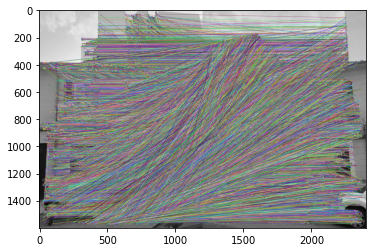

In [71]:
res = cv2.drawMatches(right_house, kp1, left_house, kp2,
                          [m for m in matches], None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(res)
plt.show()

In [72]:
matches = filter_matches(method="DIST", matches=matches, min_distance=64)

In [73]:
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt

In [74]:
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

In [75]:
height, width = right_house.shape
im1Reg = cv2.warpPerspective(right_house, h, (width + left_house.shape[1],height))
im1Reg[0:left_house.shape[0], 0:left_house.shape[1]] = left_house

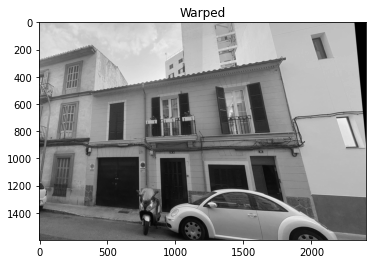

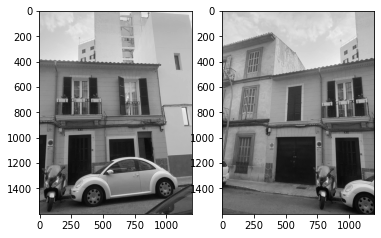

In [76]:
plt.plot()
plt.title("Warped")
plt.imshow(im1Reg, cmap="gray")

plt.show()

plt.subplot(1, 2, 1)
plt.imshow(right_house, cmap="gray")

plt.subplot(1, 2, 2)
plt.imshow(left_house, cmap="gray")

plt.show()

#### Notas finales 

A modo de breve conclusión final, se ha visto que la panorámica ha salido bastante bien en los cuatro métodos.

En cuanto a tiempo de ejecución, el ORB es el más rápido, seguido por el SURF, FAST + BRIEF y finalmente el SIFT. Puede resultar confuso que el FAST + BRIEF sea más lento que el SURF si este primero es parecido al ORB. El caso es que el método FAST señala muchos _keypoints_ , más que el resto de métodos. Y, aunque los descriptores binarios son ligeros en memoria y rápidos de operar, este alto número de puntos clave relentiza el proceso de _matching_ . Esto no sucede en ORB ya que, como se ha comentado, este implementa el método Harris para filtrar los puntos clave relevantes.